In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-


# Deep Neural Networks

## Session 23c:

## MNIST feminist Data


<img src='../../images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
# Lets import some libraries
import os

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

from datetime import datetime, timedelta

from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, confusion_matrix

import tensorflow as tf

%matplotlib inline

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')

if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
# Strictly for tensorflow version 2.12
### To hide bugs throwing warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [5]:
# Some basic parameters

inpDir = '/home/dai/6. DNN/CNN/Flower' # location where input data is stored
outDir = '../output' # location to store outputs
modelDir='../model'
subDir='flower_photos'
altName = 'Grp_2_project'



RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible results

EPOCHS = 60  # number of cycles to run

ALPHA = 0.001  # learning rate

TEST_SIZE = 0.2 # What fraction we want to keep for testing

BATCH_SIZE = 32

FACTOR_LR = 0.5

LR_PATIENCE = 2

PATIENCE = 15
IMG_HEIGHT = 190
IMG_WIDTH = 190


# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (12,9),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }
CMAP = plt.cm.brg

plt.rcParams.update(params) # update rcParams

## Helper Function

In [6]:
###-----------------------------------
### Function to plot Loss Curve
###-----------------------------------

def plot_tf_hist(hist_df):
    '''
    Args:
      hist_df : pandas Dataframe with four columns
                For 'x' values, we will use index
    '''
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12

    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y3] == hist_df[y3].min()]

    ax = axes[0]

    hist_df.plot(y = [y1,y3], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y3].to_numpy()[0]), # location of text
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.set_title('Errors')
    ax.grid();
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y2, y4], ax = ax, colormap=CMAP)

    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y4].to_numpy()[0]), # location of text
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow


    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.grid()
    ax.legend(loc = 'lower left')

    plt.tight_layout()

In [7]:
def fn_plot_label(tr_ds, ts_ds):


    plt.figure(figsize = (15,5))  # instantiate the figure

    # -----------------------------------------------------------------------------------------

    # labels for the training set

    plt.subplot(1,2,1) # first of the 2

    train_labels = tf.concat([lbl for img, lbl in tr_ds], axis = 0).numpy() # get the labels

    unique, _, counts = tf.unique_with_counts(train_labels) # get counts

    plt.bar(range(len(unique)), counts, align='center', color = 'DarkBlue') # barplot the counts

    plt.xticks(range(len(unique)), class_names)

    plt.title('Training set')


    # -----------------------------------------------------------------------------------------

    # labels for the testing set

    plt.subplot(1,2,2)

    test_labels = tf.concat([lbl for img, lbl in ts_ds], axis = 0).numpy()

    unique_tst, _, counts = tf.unique_with_counts(test_labels)

    plt.bar(range(len(unique_tst)), counts, align='center', color = 'Orange')

    plt.xticks(range(len(unique)), class_names)

    plt.title('Testing set')


###  Using Flower dataset

## Converting to Datsets  from a directory

In [8]:
data_dir = 'Flower/flower_photos'
data_dir

'Flower/flower_photos'

In [9]:
os.listdir(data_dir)

FileNotFoundError: ignored

In [ ]:
# Creating training data

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,  # path to the data directory
    validation_split=TEST_SIZE, # What is the ratio of validation data
    subset='training', #purpose
    seed=RANDOM_STATE,
    image_size=[IMG_HEIGHT, IMG_WIDTH], # images of all the sizes will be squeezed to 150 x 150 image size
    batch_size= BATCH_SIZE
)

# test data

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,  # path to the data directory
    validation_split=TEST_SIZE, # What is the ratio of validation data
    subset='validation', #purpose
    seed=RANDOM_STATE,
    image_size=[IMG_HEIGHT, IMG_WIDTH], # images of all the sizes will be squeezed to 150 x 150 image size
    batch_size= BATCH_SIZE
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [ ]:
# is it picking class names
class_names = train_ds.class_names
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

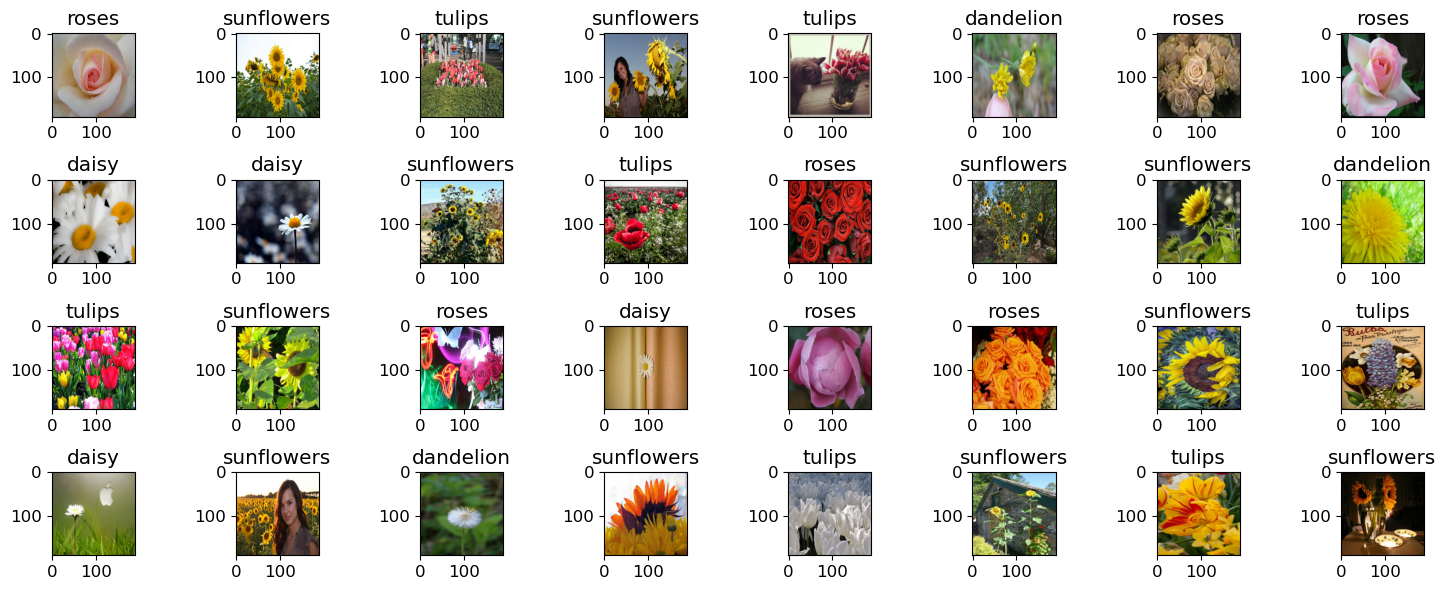

In [ ]:
plt.figure(figsize=(15,6))

for images, lables in train_ds.take(1):  # taking one batch from the dataset

    for i in range(BATCH_SIZE): # looping over one batch

        row = 4

        plt.subplot(row, BATCH_SIZE // 4, i+1) # Access the axis

        plt.grid(False)  # no grid

        plt.imshow(images[i].numpy().astype('uint8'))  # Show image, (convert to numpy and int)

        plt.title(class_names[lables[i]])

    plt.tight_layout()

plt.show()

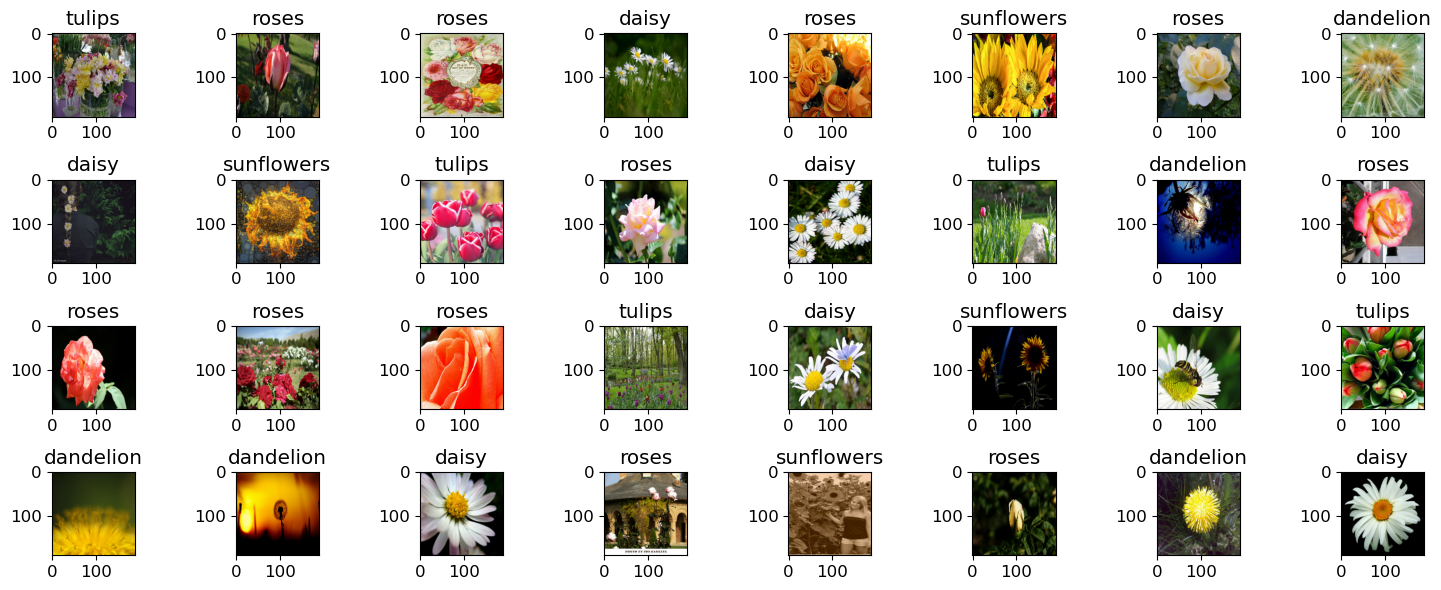

In [ ]:
plt.figure(figsize=(15,6))

for images, lables in test_ds.take(1):  # taking one batch from the dataset

    for i in range(BATCH_SIZE): # looping over one batch

        row = 4

        plt.subplot(row, BATCH_SIZE // 4, i+1) # Access the axis

        plt.grid(False)  # no grid

        plt.imshow(images[i].numpy().astype('uint8'))  # Show image, (convert to numpy and int)

        plt.title(class_names[lables[i]])

    plt.tight_layout()

plt.show()

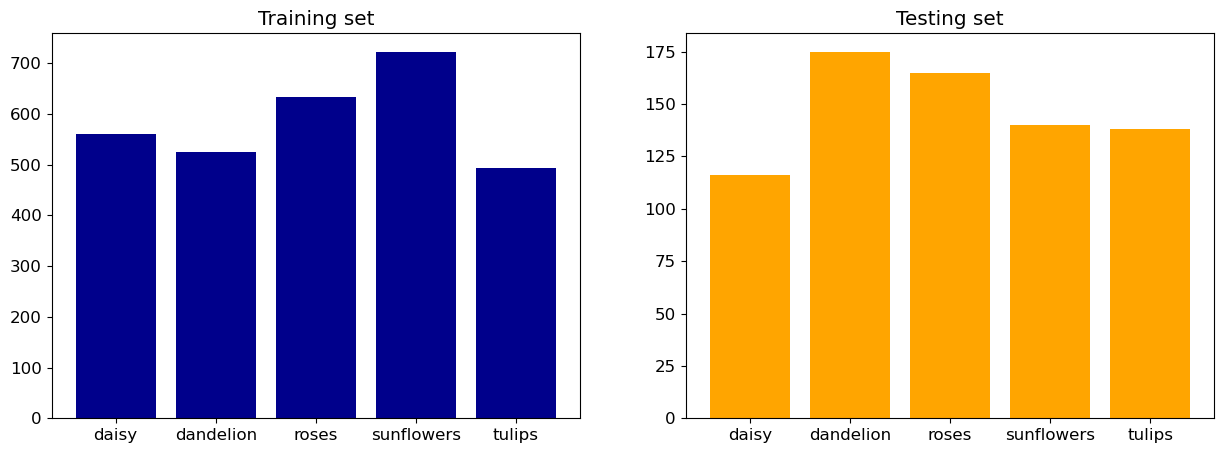

In [ ]:
fn_plot_label(train_ds, test_ds)

In [ ]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)

##  Random Zoom

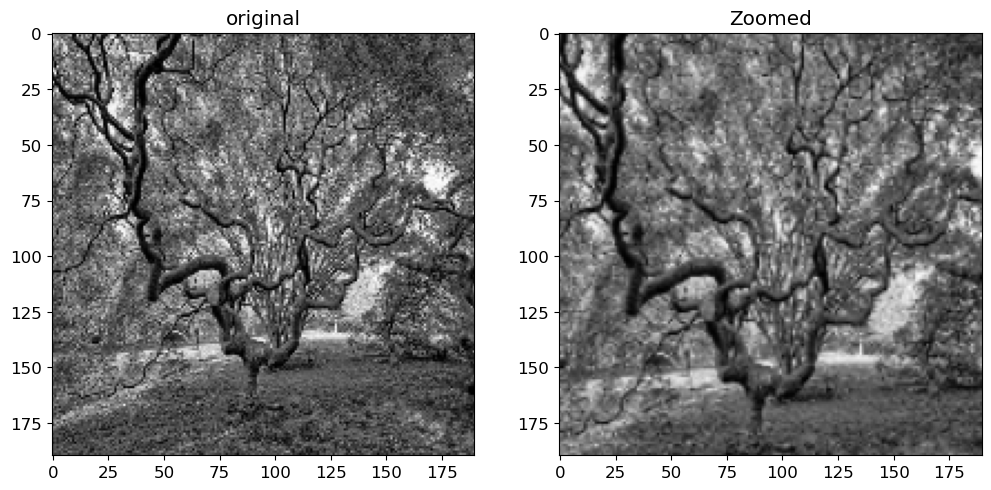

In [ ]:
# method in tensorflow to randomly zoom

layer = tf.keras.layers.RandomZoom(height_factor = (-0.2, -0.2), # range for the zooming (given in the form of tuple)
                                   width_factor = (-0.2, -0.2)
                                  )

plt.figure()

img_num = 3

for image, label in test_ds.take(1): # get one batch

    out_img = layer(image)

    plt.subplot(1,2,1)

    plt.title('original')

    plt.imshow(image[img_num].numpy().astype('uint8'))


    plt.subplot(1,2,2)

    plt.title('Zoomed')

    plt.imshow(out_img[img_num].numpy().astype('uint8'))

##  Random Rotation

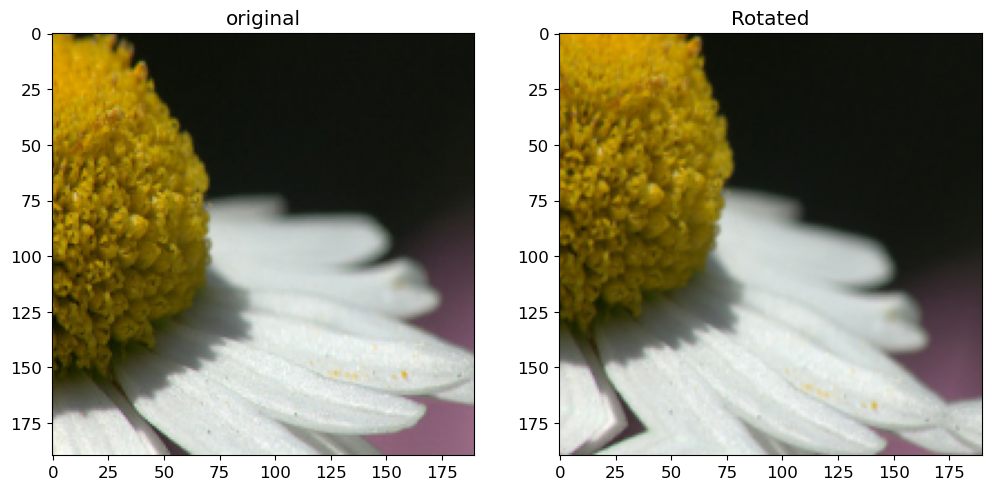

In [ ]:
# applying method to radomly rotate a image

layer = tf.keras.layers.RandomRotation(factor = (-0.2, 0.3),
                                       fill_mode='reflect', #The input is extended by reflecting about the edge of the last pixel.
                                       interpolation='bilinear'
                                      )

plt.figure()

img_num = 3

for image, label in test_ds.take(1): # get one batch

    out_img = layer(image)

    plt.subplot(1,2,1)

    plt.title('original')

    plt.imshow(image[img_num].numpy().astype('uint8'))


    plt.subplot(1,2,2)

    plt.title('Rotated')

    plt.imshow(out_img[img_num].numpy().astype('uint8'))

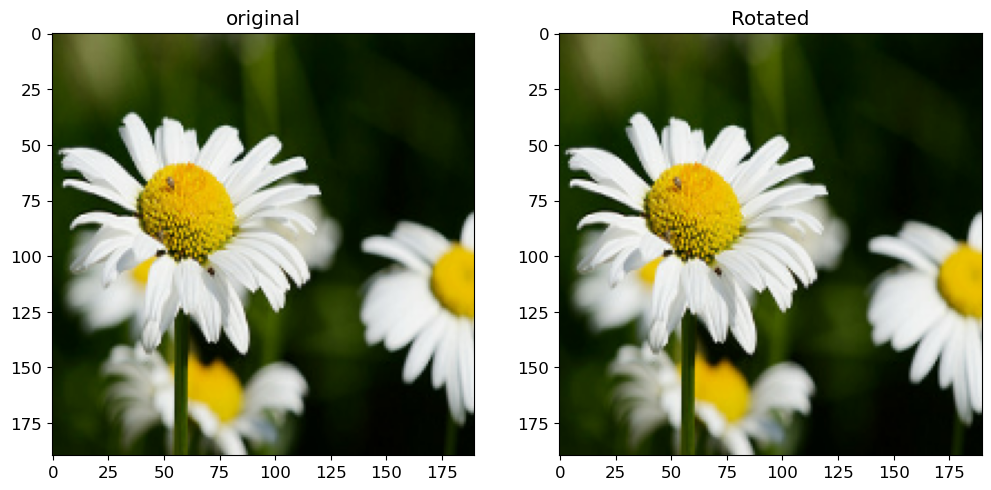

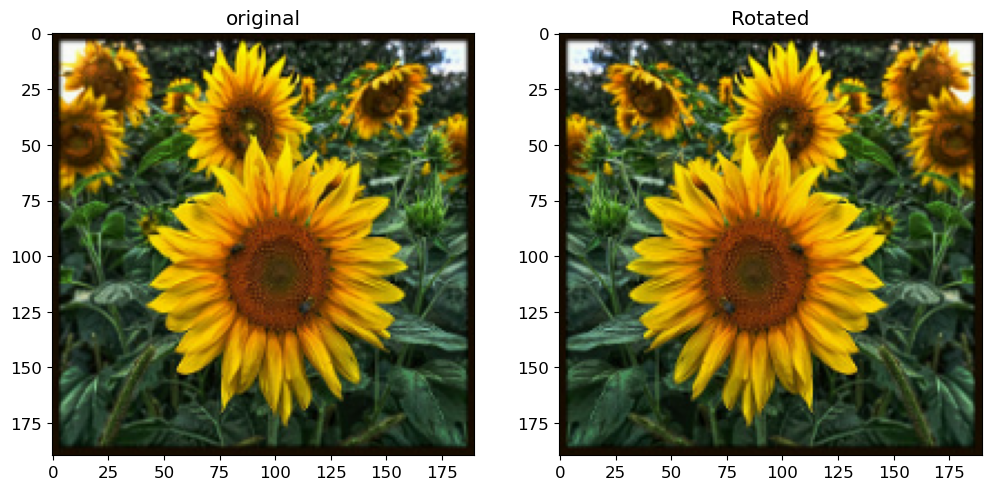

In [ ]:
# applying method to radomly rotate a image

layer = tf.keras.layers.RandomFlip(mode='horizontal_and_vertical')


plt.figure()

img_num = 3

for image, label in test_ds.take(1): # get one batch

    out_img = layer(image)

    plt.subplot(1,2,1)

    plt.title('original')

    plt.imshow(image[img_num].numpy().astype('uint8'))


    plt.subplot(1,2,2)

    plt.title('Rotated')

    plt.imshow(out_img[img_num].numpy().astype('uint8'))

plt.figure()

img_num = 3

for image, label in test_ds.take(1): # get one batch

    out_img = layer(image)

    plt.subplot(1,2,1)

    plt.title('original')

    plt.imshow(image[img_num].numpy().astype('uint8'))


    plt.subplot(1,2,2)

    plt.title('Rotated')

    plt.imshow(out_img[img_num].numpy().astype('uint8'))

In [ ]:
train_ds = train_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)

test_ds = test_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)

In [ ]:
densenet_model = tf.keras.applications.DenseNet169(weights='imagenet', include_top = False,
                                                  input_shape=(IMG_HEIGHT, IMG_WIDTH,3))

51877672/51877672 [==============================] - 5s 0us/step


In [ ]:
for layer in densenet_model.layers:

    layer.trainable = False

In [ ]:
densenet_model.summary()

Model: "densenet169"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 190, 190, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 196, 196, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 95, 95, 64)           9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 95, 95, 64)           256       ['conv1/conv[0][0]']

 conv2_block4_0_bn (BatchNo  (None, 48, 48, 160)          640       ['conv2_block3_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block4_0_relu (Activ  (None, 48, 48, 160)          0         ['conv2_block4_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_block4_1_conv (Conv2  (None, 48, 48, 128)          20480     ['conv2_block4_0_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv2_block4_1_bn (BatchNo  (None, 48, 48, 128)          512       ['conv2_block4_1_conv[0][0]'] 
 rmalizati

 rmalization)                                                                                     
                                                                                                  
 conv3_block1_1_relu (Activ  (None, 24, 24, 128)          0         ['conv3_block1_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block1_2_conv (Conv2  (None, 24, 24, 32)           36864     ['conv3_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block1_concat (Conca  (None, 24, 24, 160)          0         ['pool2_pool[0][0]',          
 tenate)                                                             'conv3_block1_2_conv[0][0]'] 
          

 conv3_block5_1_bn (BatchNo  (None, 24, 24, 128)          512       ['conv3_block5_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block5_1_relu (Activ  (None, 24, 24, 128)          0         ['conv3_block5_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block5_2_conv (Conv2  (None, 24, 24, 32)           36864     ['conv3_block5_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block5_concat (Conca  (None, 24, 24, 288)          0         ['conv3_block4_concat[0][0]', 
 tenate)  

                                                                                                  
 conv3_block9_1_bn (BatchNo  (None, 24, 24, 128)          512       ['conv3_block9_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block9_1_relu (Activ  (None, 24, 24, 128)          0         ['conv3_block9_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block9_2_conv (Conv2  (None, 24, 24, 32)           36864     ['conv3_block9_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_blo

 pool3_pool (AveragePooling  (None, 12, 12, 256)          0         ['pool3_conv[0][0]']          
 2D)                                                                                              
                                                                                                  
 conv4_block1_0_bn (BatchNo  (None, 12, 12, 256)          1024      ['pool3_pool[0][0]']          
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_0_relu (Activ  (None, 12, 12, 256)          0         ['conv4_block1_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_1_conv (Conv2  (None, 12, 12, 128)          32768     ['conv4_block1_0_relu[0][0]'] 
 D)       

                                                                                                  
 conv4_block4_concat (Conca  (None, 12, 12, 384)          0         ['conv4_block3_concat[0][0]', 
 tenate)                                                             'conv4_block4_2_conv[0][0]'] 
                                                                                                  
 conv4_block5_0_bn (BatchNo  (None, 12, 12, 384)          1536      ['conv4_block4_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block5_0_relu (Activ  (None, 12, 12, 384)          0         ['conv4_block5_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block8_concat (Conca  (None, 12, 12, 512)          0         ['conv4_block7_concat[0][0]', 
 tenate)                                                             'conv4_block8_2_conv[0][0]'] 
                                                                                                  
 conv4_block9_0_bn (BatchNo  (None, 12, 12, 512)          2048      ['conv4_block8_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block9_0_relu (Activ  (None, 12, 12, 512)          0         ['conv4_block9_0_bn[0][0]']   
 ation)                                                                                           
          

 conv4_block12_2_conv (Conv  (None, 12, 12, 32)           36864     ['conv4_block12_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block12_concat (Conc  (None, 12, 12, 640)          0         ['conv4_block11_concat[0][0]',
 atenate)                                                            'conv4_block12_2_conv[0][0]']
                                                                                                  
 conv4_block13_0_bn (BatchN  (None, 12, 12, 640)          2560      ['conv4_block12_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_block13_0_relu (Acti  (None, 12, 12, 640)          0         ['conv4_block13_0_bn[0][0]']  
 vation)  

                                                                                                  
 conv4_block16_2_conv (Conv  (None, 12, 12, 32)           36864     ['conv4_block16_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block16_concat (Conc  (None, 12, 12, 768)          0         ['conv4_block15_concat[0][0]',
 atenate)                                                            'conv4_block16_2_conv[0][0]']
                                                                                                  
 conv4_block17_0_bn (BatchN  (None, 12, 12, 768)          3072      ['conv4_block16_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_blo

 vation)                                                                                          
                                                                                                  
 conv4_block20_2_conv (Conv  (None, 12, 12, 32)           36864     ['conv4_block20_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block20_concat (Conc  (None, 12, 12, 896)          0         ['conv4_block19_concat[0][0]',
 atenate)                                                            'conv4_block20_2_conv[0][0]']
                                                                                                  
 conv4_block21_0_bn (BatchN  (None, 12, 12, 896)          3584      ['conv4_block20_concat[0][0]']
 ormalization)                                                                                    
          

 conv4_block24_1_relu (Acti  (None, 12, 12, 128)          0         ['conv4_block24_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block24_2_conv (Conv  (None, 12, 12, 32)           36864     ['conv4_block24_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block24_concat (Conc  (None, 12, 12, 1024)         0         ['conv4_block23_concat[0][0]',
 atenate)                                                            'conv4_block24_2_conv[0][0]']
                                                                                                  
 conv4_block25_0_bn (BatchN  (None, 12, 12, 1024)         4096      ['conv4_block24_concat[0][0]']
 ormalizat

                                                                                                  
 conv4_block28_1_relu (Acti  (None, 12, 12, 128)          0         ['conv4_block28_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block28_2_conv (Conv  (None, 12, 12, 32)           36864     ['conv4_block28_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block28_concat (Conc  (None, 12, 12, 1152)         0         ['conv4_block27_concat[0][0]',
 atenate)                                                            'conv4_block28_2_conv[0][0]']
                                                                                                  
 conv4_blo

 ormalization)                                                                                    
                                                                                                  
 conv4_block32_1_relu (Acti  (None, 12, 12, 128)          0         ['conv4_block32_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block32_2_conv (Conv  (None, 12, 12, 32)           36864     ['conv4_block32_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block32_concat (Conc  (None, 12, 12, 1280)         0         ['conv4_block31_concat[0][0]',
 atenate)                                                            'conv4_block32_2_conv[0][0]']
          

                                                                                                  
 conv5_block4_0_bn (BatchNo  (None, 6, 6, 736)            2944      ['conv5_block3_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block4_0_relu (Activ  (None, 6, 6, 736)            0         ['conv5_block4_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block4_1_conv (Conv2  (None, 6, 6, 128)            94208     ['conv5_block4_0_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_blo

 tenate)                                                             'conv5_block7_2_conv[0][0]'] 
                                                                                                  
 conv5_block8_0_bn (BatchNo  (None, 6, 6, 864)            3456      ['conv5_block7_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block8_0_relu (Activ  (None, 6, 6, 864)            0         ['conv5_block8_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block8_1_conv (Conv2  (None, 6, 6, 128)            110592    ['conv5_block8_0_relu[0][0]'] 
 D)                                                                                               
          

 conv5_block11_concat (Conc  (None, 6, 6, 992)            0         ['conv5_block10_concat[0][0]',
 atenate)                                                            'conv5_block11_2_conv[0][0]']
                                                                                                  
 conv5_block12_0_bn (BatchN  (None, 6, 6, 992)            3968      ['conv5_block11_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv5_block12_0_relu (Acti  (None, 6, 6, 992)            0         ['conv5_block12_0_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv5_block12_1_conv (Conv  (None, 6, 6, 128)            126976    ['conv5_block12_0_relu[0][0]']
 2D)      

                                                                                                  
 conv5_block15_concat (Conc  (None, 6, 6, 1120)           0         ['conv5_block14_concat[0][0]',
 atenate)                                                            'conv5_block15_2_conv[0][0]']
                                                                                                  
 conv5_block16_0_bn (BatchN  (None, 6, 6, 1120)           4480      ['conv5_block15_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv5_block16_0_relu (Acti  (None, 6, 6, 1120)           0         ['conv5_block16_0_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv5_blo

 2D)                                                                                              
                                                                                                  
 conv5_block19_concat (Conc  (None, 6, 6, 1248)           0         ['conv5_block18_concat[0][0]',
 atenate)                                                            'conv5_block19_2_conv[0][0]']
                                                                                                  
 conv5_block20_0_bn (BatchN  (None, 6, 6, 1248)           4992      ['conv5_block19_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv5_block20_0_relu (Acti  (None, 6, 6, 1248)           0         ['conv5_block20_0_bn[0][0]']  
 vation)                                                                                          
          

 conv5_block23_2_conv (Conv  (None, 6, 6, 32)             36864     ['conv5_block23_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv5_block23_concat (Conc  (None, 6, 6, 1376)           0         ['conv5_block22_concat[0][0]',
 atenate)                                                            'conv5_block23_2_conv[0][0]']
                                                                                                  
 conv5_block24_0_bn (BatchN  (None, 6, 6, 1376)           5504      ['conv5_block23_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv5_block24_0_relu (Acti  (None, 6, 6, 1376)           0         ['conv5_block24_0_bn[0][0]']  
 vation)  

                                                                                                  
 conv5_block27_2_conv (Conv  (None, 6, 6, 32)             36864     ['conv5_block27_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv5_block27_concat (Conc  (None, 6, 6, 1504)           0         ['conv5_block26_concat[0][0]',
 atenate)                                                            'conv5_block27_2_conv[0][0]']
                                                                                                  
 conv5_block28_0_bn (BatchN  (None, 6, 6, 1504)           6016      ['conv5_block27_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv5_blo

 vation)                                                                                          
                                                                                                  
 conv5_block31_2_conv (Conv  (None, 6, 6, 32)             36864     ['conv5_block31_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv5_block31_concat (Conc  (None, 6, 6, 1632)           0         ['conv5_block30_concat[0][0]',
 atenate)                                                            'conv5_block31_2_conv[0][0]']
                                                                                                  
 conv5_block32_0_bn (BatchN  (None, 6, 6, 1632)           6528      ['conv5_block31_concat[0][0]']
 ormalization)                                                                                    
          

In [ ]:
num_classses = len(class_names)

In [ ]:
# Build model


initializer = tf.keras.initializers.GlorotUniform(seed=RANDOM_STATE)
reg=tf.keras.regularizers.L2(l2=0.05)


model = tf.keras.Sequential()
model.add(tf.keras.layers.RandomRotation(factor = (-0.2, 0.3)))
model.add(tf.keras.layers.RandomFlip(mode= "horizontal_and_vertical" ))



model.add(densenet_model)

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(1024,
                                kernel_initializer=initializer,
                                activation='relu'))

model.add(tf.keras.layers.Dropout(0.05))

model.add(tf.keras.layers.Dense(5,
                               kernel_initializer=initializer))

In [ ]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optim = tf.keras.optimizers.Adam()

model.compile(optimizer=optim, loss=loss_fn, metrics=['accuracy'])

###  Checkpoint

In [ ]:
filepath=os.path.join(inpDir,subDir, altName)

In [ ]:
# Early stopping callback

es_check_point=tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    min_delta=0,
    patience=PATIENCE,
    verbose=1,
    restore_best_weights=True,
    start_from_epoch=False,
)

'''

    When the loss stops decreasin for cycles = parience level, at that time we will reduce the alpha level.
    this is acieved by the ReduceLROnPlateau

'''

# Learning rate decay callback

lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=FACTOR_LR,
    patience=LR_PATIENCE,
    verbose=1,
    mode='auto'
)

model_check_point=tf.keras.callbacks.ModelCheckpoint(
    filepath,
    monitor = 'val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode = 'auto',
)

In [ ]:
history = model.fit(train_ds,
                    validation_data=test_ds,
                    batch_size=BATCH_SIZE,
                    epochs=50,
                    verbose=1,
                    callbacks=[es_check_point, lr, model_check_point]
                   )

Epoch 1/50
92/92 [==============================] - ETA: 0s - loss: 60.7385 - accuracy: 0.5160
Epoch 1: val_loss improved from inf to 8.42168, saving model to /home/dai/6. DNN/CNN/Flower/flower_photos/Grp_2_project
92/92 [==============================] - 140s 1s/step - loss: 60.7385 - accuracy: 0.5160 - val_loss: 8.4217 - val_accuracy: 0.5886 - lr: 0.0010
Epoch 2/50
92/92 [==============================] - ETA: 0s - loss: 3.5152 - accuracy: 0.5777
Epoch 2: val_loss improved from 8.42168 to 1.12713, saving model to /home/dai/6. DNN/CNN/Flower/flower_photos/Grp_2_project
92/92 [==============================] - 126s 1s/step - loss: 3.5152 - accuracy: 0.5777 - val_loss: 1.1271 - val_accuracy: 0.6104 - lr: 0.0010
Epoch 3/50
59/92 [==================>...........] - ETA: 36s - loss: 1.0068 - accuracy: 0.6308

In [ ]:
model.summary()

In [ ]:


res_df = pd.DataFrame(history.history)

plot_tf_hist(res_df)

## Prediction on the Validation data

### Reading the data from the validation directory

In [ ]:
validation_data_dir = 'Flower/flowers_validation'
validation_data_dir

'Flower/flowers_validation'

In [ ]:
os.listdir(validation_data_dir)

NameError: name 'os' is not defined